PROJECT TASK: [ Duration: 6 weeks, Score: 100 points]
1. Milestone 1: [ Duration: 2 weeks, Score: 20 points]
* Input: Interim report
* Process:
  * Step 1: Import the data
  * Step 2: Map training and testing images to its classes.
  * Step 3: Map training and testing images to its annotations.
  * Step 4: Display images with bounding box
* Output: Images mapped to its class and annotation ready to be used for deep learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Display a sample image from dataset

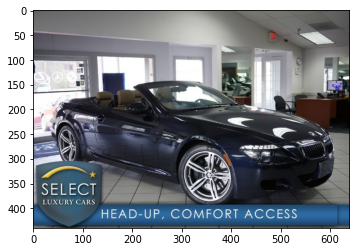

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
AUTOTUNE = tf.data.experimental.AUTOTUNE

image = Image.open('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Car Images/Train Images/BMW M6 Convertible 2010/00623.jpg')
imgplot = plt.imshow(image)
plt.show() 

Load the Car Name CSV along with the index

since 0 class is not used, create a dummy class for index 0

In [ ]:
import pandas as pd

car_labels = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Car names and make.csv', header=None, names=['Car Names'])

car_labels.loc[-1] = ['Dummy']  # adding a dummy row to avoid 0 index
car_labels.index = car_labels.index + 1  # shifting index
car_labels = car_labels.sort_index()  # sorting by index
car_labels.head()

,Car Names
0,Dummy
1,AM General Hummer SUV 2000
2,Acura RL Sedan 2012
3,Acura TL Sedan 2012
4,Acura TL Type-S 2008


Load the annotations - Box coordinates and Class for Training & Test Images

In [ ]:
columns = ['fname','b_x1', 'b_y1', 'b_x2', 'b_y2', 'class']
annotations_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Annotations/Train Annotations.csv', names=columns,skiprows=[0])
annotations_train.head()

,fname,b_x1,b_y1,b_x2,b_y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [ ]:
annotations_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Annotations/Test Annotation.csv', names=columns,skiprows=[0])
annotations_test.head()

,fname,b_x1,b_y1,b_x2,b_y2,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


Combine the Annotation data with the actual Car Label

In [ ]:
annotations_train = annotations_train.merge(car_labels, left_on='class', right_index=True)
annotations_train = annotations_train.sort_index()
annotations_train.head()

,fname,b_x1,b_y1,b_x2,b_y2,class,Car Names
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012


Create the filepath using file name and car name

In [ ]:
annotations_train['filepath'] = "/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Car Images/Train Images/" + annotations_train['Car Names'] + "/" + annotations_train['fname']

In [ ]:
annotations_train.head()

,fname,b_x1,b_y1,b_x2,b_y2,class,Car Names,filepath
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,/content/drive/MyDrive/Colab Notebooks/Capston...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,/content/drive/MyDrive/Colab Notebooks/Capston...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,/content/drive/MyDrive/Colab Notebooks/Capston...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,/content/drive/MyDrive/Colab Notebooks/Capston...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,/content/drive/MyDrive/Colab Notebooks/Capston...


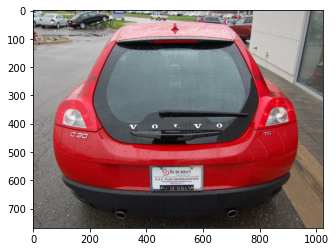

In [ ]:
image = Image.open(annotations_train.iloc[100]['filepath'])
imgplot = plt.imshow(image)
plt.show()

In [ ]:
annotations_test = annotations_test.merge(car_labels, left_on='class', right_index=True)
annotations_test = annotations_test.sort_index()
annotations_test.head()

,fname,b_x1,b_y1,b_x2,b_y2,class,Car Names
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012


In [ ]:
annotations_test['filepath'] = "/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Car Images/Test Images/" + annotations_test['Car Names'] + "/" + annotations_test['fname']
annotations_test.head()

,fname,b_x1,b_y1,b_x2,b_y2,class,Car Names,filepath
0,00001.jpg,30,52,246,147,181,Suzuki Aerio Sedan 2007,/content/drive/MyDrive/Colab Notebooks/Capston...
1,00002.jpg,100,19,576,203,103,Ferrari 458 Italia Convertible 2012,/content/drive/MyDrive/Colab Notebooks/Capston...
2,00003.jpg,51,105,968,659,145,Jeep Patriot SUV 2012,/content/drive/MyDrive/Colab Notebooks/Capston...
3,00004.jpg,67,84,581,407,187,Toyota Camry Sedan 2012,/content/drive/MyDrive/Colab Notebooks/Capston...
4,00005.jpg,140,151,593,339,185,Tesla Model S Sedan 2012,/content/drive/MyDrive/Colab Notebooks/Capston...


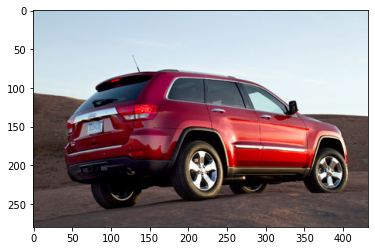

In [ ]:
image = Image.open(annotations_test.iloc[234]['filepath'])
imgplot = plt.imshow(image)
plt.show()

In [ ]:
from matplotlib.patches import Rectangle

def get_image_box(data, i):
    image = Image.open(data['filepath'][i])
    title = data['Car Names'][i]

    xy = data['b_x1'][i], data['b_y1'][i]
    width = data['b_x2'][i] - data['b_x1'][i]
    height = data['b_y2'][i] - data['b_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

In [ ]:
def display_image_with_annotations(data, i):
    image, title, rect = get_image_box(data, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

Volvo C30 Hatchback 2012


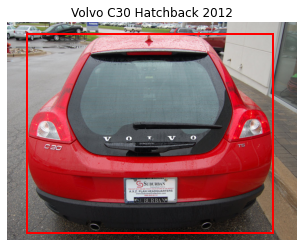

In [ ]:
display_image_with_annotations(annotations_train, 100)

Dodge Ram Pickup 3500 Crew Cab 2010


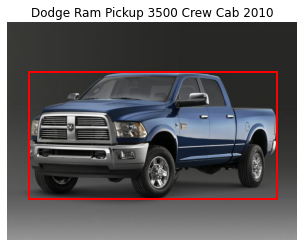

In [ ]:
display_image_with_annotations(annotations_test, 500)

In [ ]:
!pip install -q -U albumentations

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.7 MB 2.0 MB/s 


In [ ]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [ ]:
import albumentations as A

In [ ]:
img_w = 224
img_h = 224
classifier = 1
if classifier == 0:
  transform = A.Compose(
    [A.RandomSizedBBoxSafeCrop(width = img_w, height = img_h, erosion_rate=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, p=0.5),
    A.HorizontalFlip(p=0.5)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=''),
 )
else : 
  transform = A.Compose(
    [A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, p=0.5),
    A.HorizontalFlip(p=0.5)])


In [ ]:
if classifier == 0:
  categ_ids_to_names = {}
  for i in range(len(annotations_train)):
    categ_ids_to_names[annotations_train['class'][i]] = annotations_train['Car Names'][i]

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

if classifier == 0:

  def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
      """Visualizes a single bounding box on the image"""
      x_min, y_min, w, h = bbox
      x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
      cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
      ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
      cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
      cv2.putText(
          img,
          text=class_name,
          org=(x_min, y_min - int(0.3 * text_height)),
          fontFace=cv2.FONT_HERSHEY_SIMPLEX,
          fontScale=0.35, 
          color=TEXT_COLOR, 
          lineType=cv2.LINE_AA,
      )
      return img


  def visualize(image, bboxes, category_ids, category_id_to_name):
      img = image.copy()
      for bbox, category_id in zip(bboxes, category_ids):
          class_name = category_id_to_name[category_id]
           img = visualize_bbox(img, bbox, class_name)
      plt.figure(figsize=(12, 12))
      plt.axis('off')
      plt.imshow(img)

In [ ]:
import random

In [ ]:
print(annotations_train[['b_x1', 'b_y1', 'b_x2', 'b_y2']][100:101])

     b_x1  b_y1  b_x2  b_y2
100    70    39   940   742


In [ ]:
if classifier == 0:
  random.seed(12)
  transformed = transform(image=np.array(Image.open(annotations_train['filepath'][300])),
                        bboxes=np.array(annotations_train[['b_x1', 'b_y1', 'b_x2', 'b_y2']][300:301]
                        ), category_ids=[annotations_train['class'][300]])
  visualize(
      transformed['image'],
      transformed['bboxes'],
      transformed['category_ids'],
      categ_ids_to_names,
  )

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Dataset/Car Images/Train Images'

In [ ]:
label_ds = annotations_train[['class', 'filepath']].copy()
label_ds.sort_values(by = ['filepath'], axis = 0, inplace = True, ascending = True)

In [ ]:
batch_size = 1
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = 'inferred',
  label_mode = 'int',
  image_size=(img_h, img_w))

Found 8144 files belonging to 196 classes.


In [ ]:
if classifier == 1:
  def aug_fn(image):
    data = {"image":np.array(image)}
    aug_data = transform(**data)
    aug_img = aug_data["image"]
    # aug_bboxes = aug_data["bboxes"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    # aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [ ]:
if classifier == 1:
  def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
# create dataset
ds_alb = train_ds.map(process_data,
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int32)>

In [ ]:
def set_shapes(img, label, img_shape=(None,224,224,3)):
    img.set_shape(img_shape)
    label.set_shape((None,1))
    return img, label

In [ ]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

In [ ]:
input = tf.keras.Input(shape=(img_w, img_h, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(input)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(197, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy', run_eagerly=True)

model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_72 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 52, 52, 64)        369

In [ ]:
model.fit(ds_alb, epochs=5)

Epoch 1/5
255/255 [==============================] - 818s 3s/step - loss: 5.2764 - accuracy: 0.0082
Epoch 2/5
255/255 [==============================] - 816s 3s/step - loss: 5.2757 - accuracy: 0.0083
Epoch 3/5
255/255 [==============================] - 807s 3s/step - loss: 5.2748 - accuracy: 0.0083
Epoch 4/5
255/255 [==============================] - 804s 3s/step - loss: 5.2746 - accuracy: 0.0083
Epoch 5/5
255/255 [==============================] - 805s 3s/step - loss: 5.2735 - accuracy: 0.0083
